In [1]:
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from matplotlib import pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from Network import MnistModel

In [2]:
TORCH_SEED = 1
NUMPY_SEED = 1

BATCH_SIZE = 50
NUM_EPOCHS = 1

HOME_DIR = os.path.expanduser('~')
MNIST_DIR = HOME_DIR + '/MNIST/'

UsePretrainedModel = False
FixConv = True
Show = True

In [3]:
torch.manual_seed(TORCH_SEED)
np.random.seed(NUMPY_SEED)

use_gpu = torch.cuda.is_available()
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '2'
    print("GPU: {}".format(torch.cuda.current_device()))

In [4]:
transform = transforms.ToTensor()

trainset = datasets.MNIST(MNIST_DIR, train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

testset = datasets.MNIST(MNIST_DIR, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=1000)

dataloaders = {'train': trainloader, 'val': testloader}
dataset = {'train': trainset, 'val': testset}

classes = np.arange(0, 10)

In [7]:
net = MnistModel()

if use_gpu:
    net = net.cuda()

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

step_counter = 0

for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        if use_gpu:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, embeddings = net(inputs)
        loss = criterion(outputs, labels)
        # loss = F.nll_loss(F.log_softmax(outputs), labels)
        loss.backward()
        optimizer.step()

        prediction = outputs.data.max(1)[1]  # first column has actual prob.
        accuracy = float(prediction.eq(labels.data).sum()) / BATCH_SIZE * 100

        # print statistics
        running_loss += loss.data[0]
        if step_counter % 1000 == 0:    # print every 1000 mini-batches
            print('Train Step: {}\tLoss: {:.3f}\tRunning Loss: {:.3f}\tAccuracy: {:.3f}'.
                  format(step_counter, loss.data[0], running_loss, accuracy))
            running_loss = 0.0
        step_counter += 1

print('Finished Training')

Train Step: 0	Loss: 2.306	Running Loss: 2.306	Accuracy: 10.000
Train Step: 1000	Loss: 0.067	Running Loss: 402.043	Accuracy: 100.000
Finished Training


In [22]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from show_images import showgrid

Testing on one batch
Number of misclassifications: 38
Misclassified predictions: [6, 5, 0, 4, 5, 3, 1, 7, 7, 7, 9, 8, 0, 5, 5, 1, 4, 3, 1, 7, 3, 7, 3, 8, 8, 6, 1, 3, 9, 5, 8, 9, 7, 8, 5, 0, 9, 0]


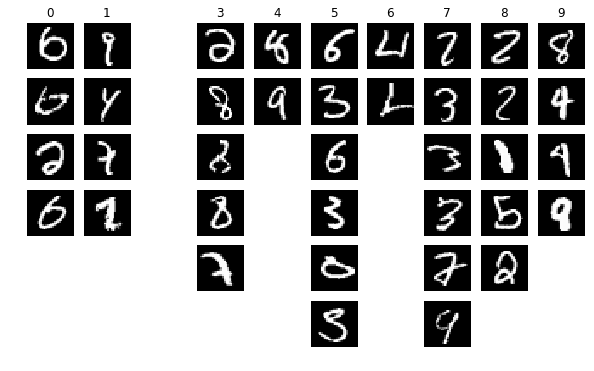

In [36]:
print("Testing on one batch")

dataiter = iter(testloader)
images, labels = dataiter.next()  # images: torch.FloatTensor of [1000, 1, 28, 28]

misclassified_images = []
misclassified_labels = []

if use_gpu:
    outputs, embeddings = net(Variable(images).cuda())
else:
    outputs, embeddings = net(Variable(images))

_, predictions = torch.max(outputs.data, 1)

fails = predictions != labels
print("Number of misclassifications: {}".format(fails.sum()))
misclassified_idxs = [i for i, x in enumerate(fails) if x]

misclassified_images = [images[idx] for idx in misclassified_idxs]
misclassified_labels = [labels[idx] for idx in misclassified_idxs]
misclassified_predictions = [predictions[idx] for idx in misclassified_idxs]
print("Misclassified predictions: {}".format(misclassified_predictions))

showgrid(misclassified_images, misclassified_predictions, classes)



# if Show:
#     title = ' '.join('%s' % classes[label] for label in labels)
#     imshow(torchvision.utils.make_grid(images), title)

# print('GroundTruth: ', ' '.join('%s' % classes[label] for label in labels))
# print('Predicted: ', ' '.join('%s' % classes[pred] for pred in predictions))

In [30]:
print(embeddings.data.shape)
print(labels.shape)

torch.Size([1000, 1024])
torch.Size([1000])


In [34]:
from tsne import tsne

# load up data
x_data = embeddings.data.numpy()
y_data = labels.numpy()

# convert image data to float64 matrix. float64 is need for bh_sne
x_data = np.asarray(x_data).astype('float64')
x_data = x_data.reshape((x_data.shape[0], -1))

# perform t-SNE embedding
vis_data = tsne(x_data)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  1000 ...
Computing P-values for point  500  of  1000 ...
Mean value of sigma:  6.68764917823
Iteration  10 : error is  16.0984877494
Iteration  20 : error is  13.2833892638
Iteration  30 : error is  12.036415186
Iteration  40 : error is  11.6304793649
Iteration  50 : error is  11.530244148
Iteration  60 : error is  11.4894612965
Iteration  70 : error is  11.4618464715
Iteration  80 : error is  11.4353727244
Iteration  90 : error is  11.412440339
Iteration  100 : error is  11.3943435505
Iteration  110 : error is  1.17333565273
Iteration  120 : error is  0.993287098014
Iteration  130 : error is  0.88694051045
Iteration  140 : error is  0.819135056127
Iteration  150 : error is  0.77028601904
Iteration  160 : error is  0.733525577713
Iteration  170 : error is  0.706677355115
Iteration  180 : error is  0.686684145581
Iteration  190 : error is  0.671224071988
Iteration  200 : error is  0.

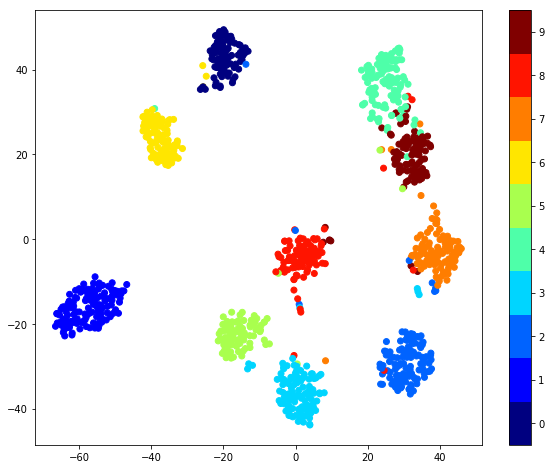

In [35]:
# plot the result
vis_x = vis_data[:, 0]
vis_y = vis_data[:, 1]

plt.scatter(vis_x, vis_y, c=y_data, cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()